## Penerapan Naive Bayes pada Website Sistem Deteksi SMS Spam
- NAMA : ANDI LAKSONO
- NIM : A11.2022.14839
- KELP : A11.4701
### Ringkasan Proyek
Di Indonesia, volume SMS spam yang sangat tinggi menempati peringkat keenam secara global. Masalah ini menciptakan tantangan besar dalam menjaga keamanan komunikasi digital. Metode filter manual sering kali kurang efektif dalam mendeteksi pola spam yang terus berkembang dan semakin kompleks. Akibatnya, banyak pengguna masih menghadapi gangguan serta risiko seperti penipuan, pencurian data, dan kerugian finansial.
### Tujuan
Proyek ini bertujuan untuk mengembangkan sistem deteksi SMS spam menggunakan algoritma Naive Bayes yang diimplementasikan dalam bentuk website.


### Alur Penyelesaian
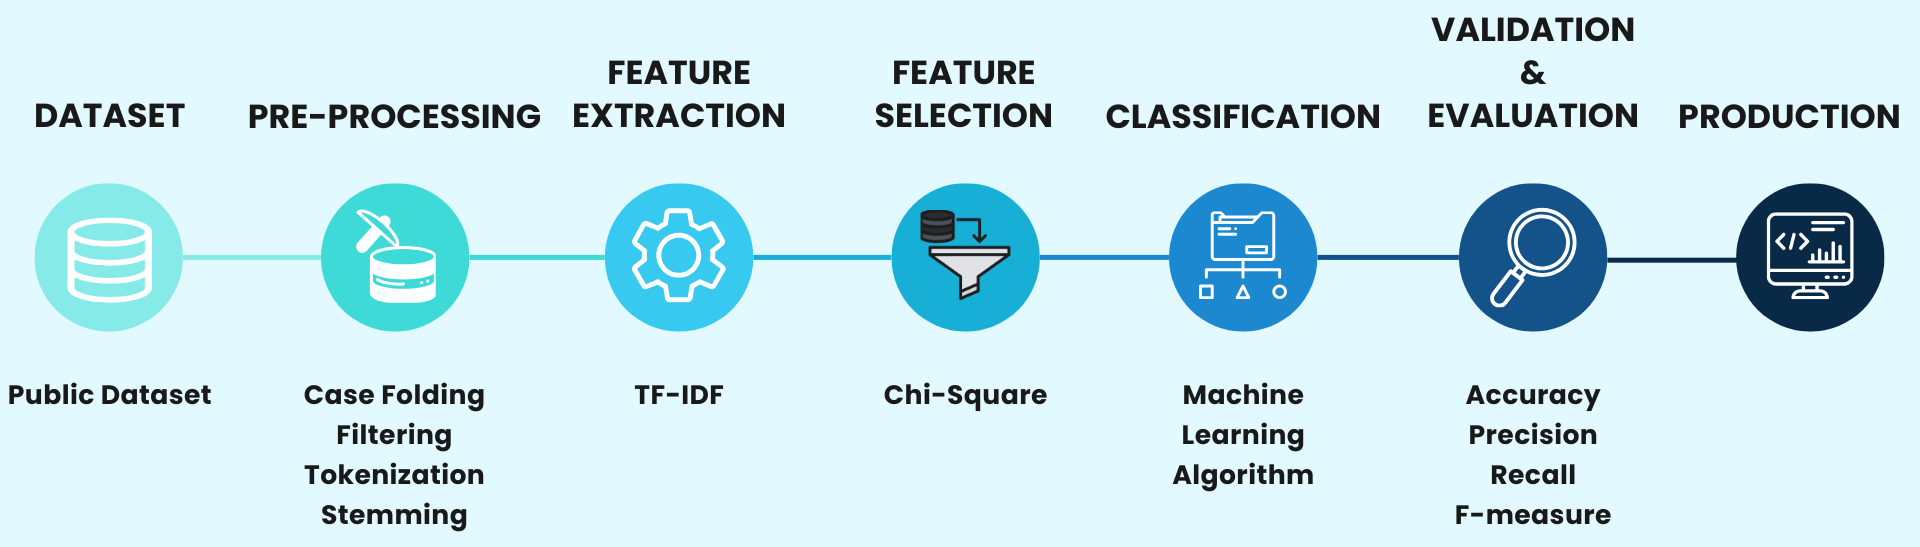

## Load Library

In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [77]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to C:\Users\My-
[nltk_data]     PC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## load dataset
Dataset yang digunakan adalah dataset public yang berasal dari Kaggle. URL : https://www.kaggle.com/code/raflyahmadzainur/deteksi-spam-tf-idf/input

Dataset ini terdiri dari 2.636 baris data, yang berisi kategori pesan (spam/ham) serta isi pesan yang diterima.

In [78]:
data = pd.read_csv('spam.csv')
data.head()

,Kategori,Pesan
0,spam,Secara alami tak tertahankan identitas perusah...
1,spam,Fanny Gunslinger Perdagangan Saham adalah Merr...
2,spam,Rumah -rumah baru yang luar biasa menjadi muda...
3,spam,4 Permintaan Khusus Pencetakan Warna Informasi...
4,spam,"Jangan punya uang, dapatkan CD perangkat lunak..."


In [79]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2636 entries, 0 to 2635
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Kategori  2636 non-null   object
 1   Pesan     2636 non-null   object
dtypes: object(2)
memory usage: 41.3+ KB


In [80]:
data['Kategori'].unique()

array(['spam', 'ham'], dtype=object)

Untuk memudahkan proses pemodelan, label Kategori tersebut akan diubah menjadi nilai numerik, di mana "spam" akan dikonversi menjadi 0 dan "ham" menjadi 1. Proses ini diperlukan karena sebagian besar algoritma machine learning, termasuk Naive Bayes, membutuhkan data dalam format numerik untuk melakukan perhitungan.

In [81]:
Kategori = {'spam':0, 'ham':1}

data['Kategori'] = data['Kategori'].map(Kategori)

In [82]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2636 entries, 0 to 2635
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Kategori  2636 non-null   int64 
 1   Pesan     2636 non-null   object
dtypes: int64(1), object(1)
memory usage: 41.3+ KB


Selain itu, dilakukan perubahan nama kolom pada dataset agar lebih sesuai dengan konvensi dan memudahkan pemrosesan data. Kolom Kategori akan diubah menjadi label, yang lebih menggambarkan peran kolom tersebut sebagai target variabel dalam prediksi. Sedangkan kolom Pesan akan diganti menjadi teks, yang lebih sesuai dengan isinya yang berisi teks pesan yang akan dianalisis.

In [83]:
data.rename(columns = {"Kategori": "label", "Pesan": "teks"}, inplace = True)

In [84]:
data.head()

,label,teks
0,0,Secara alami tak tertahankan identitas perusah...
1,0,Fanny Gunslinger Perdagangan Saham adalah Merr...
2,0,Rumah -rumah baru yang luar biasa menjadi muda...
3,0,4 Permintaan Khusus Pencetakan Warna Informasi...
4,0,"Jangan punya uang, dapatkan CD perangkat lunak..."


## text preprocessing
Dalam pengembangan sistem deteksi SMS spam, tahap preprocessing memegang peranan untuk memastikan kualitas data yang akan diproses oleh model machine learning. Implementasi preprocessing dilakukan beberapa langkah utama untuk memastikan data teks siap digunakan dalam pelatihan model machine learning.

## case folding
Case folding merupakan proses standarisasi karakter dalam teks menjadi bentuk yang seragam.

In [85]:
import re

# membuat fungsi untuk case folding
def casefolding(text):
    text = text.lower() # mengubah semua teks menjadi huruf kecil
    text = re.sub(r'https?://\S+|www\.\S+', '', text) # menghapus url
    text = re.sub(r'[-+]?[0-9]+', '', text) # menghapus angka
    text = re.sub(r'[^\w\s]', '', text) # menghapus karakter khusus dan tanda baca
    text = text.strip() # menghapus spasi berlebih
    return text

In [86]:
# membandingkan sebelum dan sesudah case folding
raw_sample = data['teks'].iloc[100]
case_folding = casefolding(raw_sample)

print('raw data\t : ', raw_sample)
print('case folding\t : ', case_folding)

raw data	 :  Re: Pil yang Disetujui Dokter LGW Seorang pria yang diberkahi dengan palu 7 - 8 "lebih baik dilengkapi daripada seorang pria dengan palu 5 - 6". Apakah Anda lebih suka lebih dari cukup untuk menyelesaikan pekerjaan atau gagal. itu benar -benar terserah Anda. Metode kami dijamin akan meningkatkan ukuran Anda dengan 1 - 3 "datang ke sini dan lihat bagaimana - - - - email net ini disponsori oleh: ThinkGeek Selamat datang di Geek Heaven. http: / / thinkgeek. milis
case folding	 :  re pil yang disetujui dokter lgw seorang pria yang diberkahi dengan palu    lebih baik dilengkapi daripada seorang pria dengan palu    apakah anda lebih suka lebih dari cukup untuk menyelesaikan pekerjaan atau gagal itu benar benar terserah anda metode kami dijamin akan meningkatkan ukuran anda dengan    datang ke sini dan lihat bagaimana     email net ini disponsori oleh thinkgeek selamat datang di geek heaven http   thinkgeek milis


## word normalization

In [87]:
key_norm = pd.read_csv('key_norm.csv')

def text_normalize(text):
    text = ' '.join([key_norm[key_norm['singkat'] == word]['hasil'].values[0]
    if (key_norm['singkat'] == word).any()
    else word for word in text.split()
    ])

    text == str.lower(text)
    return text

In [88]:
# membandingkan before dan after word normalization

raw_data = data['teks'].iloc[100]
word_normal = text_normalize(case_folding)

print('raw data\t:', raw_data)
print('word normalize\t:', word_normal)

raw data	: Re: Pil yang Disetujui Dokter LGW Seorang pria yang diberkahi dengan palu 7 - 8 "lebih baik dilengkapi daripada seorang pria dengan palu 5 - 6". Apakah Anda lebih suka lebih dari cukup untuk menyelesaikan pekerjaan atau gagal. itu benar -benar terserah Anda. Metode kami dijamin akan meningkatkan ukuran Anda dengan 1 - 3 "datang ke sini dan lihat bagaimana - - - - email net ini disponsori oleh: ThinkGeek Selamat datang di Geek Heaven. http: / / thinkgeek. milis
word normalize	: re pil yang disetujui dokter lgw seorang pria yang diberkahi dengan palu lebih baik dilengkapi daripada seorang pria dengan palu apakah anda lebih suka lebih dari cukup untuk menyelesaikan pekerjaan atau gagal itu benar benar terserah anda metode kami dijamin akan meningkatkan ukuran anda dengan datang ke sini dan lihat bagaimana email net ini disponsori oleh thinkgeek selamat datang di geek heaven http thinkgeek milis


## filtering (stopword removal)
Filtering merupakan tahapan krusial dalam reduksi dimensi data dengan mengeliminasi kata-kata yang dianggap tidak signifikan dalam proses klasifikasi (stopwords). Proses ini menggunakan daftar stopwords bahasa Indonesia yang telah dikurasi, mencakup kata-kata umum seperti "yang", "di", "ke", "dari", dan sebagainya. Eliminasi stopwords ini berkontribusi dalam meningkatkan efisiensi komputasi dan mengurangi noise dalam data.

In [89]:
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords

stopwords_ind = stopwords.words('indonesian')

In [90]:
len (stopwords_ind)

758

In [91]:
stopwords_ind

['ada',
 'adalah',
 'adanya',
 'adapun',
 'agak',
 'agaknya',
 'agar',
 'akan',
 'akankah',
 'akhir',
 'akhiri',
 'akhirnya',
 'aku',
 'akulah',
 'amat',
 'amatlah',
 'anda',
 'andalah',
 'antar',
 'antara',
 'antaranya',
 'apa',
 'apaan',
 'apabila',
 'apakah',
 'apalagi',
 'apatah',
 'artinya',
 'asal',
 'asalkan',
 'atas',
 'atau',
 'ataukah',
 'ataupun',
 'awal',
 'awalnya',
 'bagai',
 'bagaikan',
 'bagaimana',
 'bagaimanakah',
 'bagaimanapun',
 'bagi',
 'bagian',
 'bahkan',
 'bahwa',
 'bahwasanya',
 'baik',
 'bakal',
 'bakalan',
 'balik',
 'banyak',
 'bapak',
 'baru',
 'bawah',
 'beberapa',
 'begini',
 'beginian',
 'beginikah',
 'beginilah',
 'begitu',
 'begitukah',
 'begitulah',
 'begitupun',
 'bekerja',
 'belakang',
 'belakangan',
 'belum',
 'belumlah',
 'benar',
 'benarkah',
 'benarlah',
 'berada',
 'berakhir',
 'berakhirlah',
 'berakhirnya',
 'berapa',
 'berapakah',
 'berapalah',
 'berapapun',
 'berarti',
 'berawal',
 'berbagai',
 'berdatangan',
 'beri',
 'berikan',
 'berikut'

In [92]:
# membuat fungsi stopword removal

# menambahkan kata kedalam stopwords
more_stopword = ['tsel', 'gb', 'rb', 'btw']
stopwords_ind = stopwords_ind + more_stopword

def remove_stop_word(text):
    clean_words = []
    text = text.split()
    for word in text:
        if word not in stopwords_ind:
            clean_words.append(word)
    return " ".join(clean_words)

In [93]:
# membandingkan sebelum dan sesudah stopwords removal
raw_sample = data['teks'].iloc[100]
case_folding = casefolding(raw_sample)
stopwords_removal = remove_stop_word(case_folding)

print('raw data \t\t:', raw_data)
print('case folding \t\t:', case_folding)
print('stopword removal \t:', stopwords_removal)

raw data 		: Re: Pil yang Disetujui Dokter LGW Seorang pria yang diberkahi dengan palu 7 - 8 "lebih baik dilengkapi daripada seorang pria dengan palu 5 - 6". Apakah Anda lebih suka lebih dari cukup untuk menyelesaikan pekerjaan atau gagal. itu benar -benar terserah Anda. Metode kami dijamin akan meningkatkan ukuran Anda dengan 1 - 3 "datang ke sini dan lihat bagaimana - - - - email net ini disponsori oleh: ThinkGeek Selamat datang di Geek Heaven. http: / / thinkgeek. milis
case folding 		: re pil yang disetujui dokter lgw seorang pria yang diberkahi dengan palu    lebih baik dilengkapi daripada seorang pria dengan palu    apakah anda lebih suka lebih dari cukup untuk menyelesaikan pekerjaan atau gagal itu benar benar terserah anda metode kami dijamin akan meningkatkan ukuran anda dengan    datang ke sini dan lihat bagaimana     email net ini disponsori oleh thinkgeek selamat datang di geek heaven http   thinkgeek milis
stopword removal 	: re pil disetujui dokter lgw pria diberkahi palu

## Stemming
Implementasi stemming menggunakan library Sastrawi merupakan salah satu langkah dalam preprocessing teks bahasa Indonesia. Proses ini mereduksi kata berimbuhan menjadi kata dasar, sehingga variasi morfologis dari kata yang sama dapat dikenali sebagai entitas yang sama oleh sistem.

In [94]:
!pip -q install sastrawi

In [95]:
# merubah kata menjadi kata dasar
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

factory = StemmerFactory()
stemmer = factory.create_stemmer()

# membuat fungsi untuk stemming bahasa indonesia
def stemming(text):
    text = stemmer.stem(text)
    return text

In [96]:
# membandingkan sebelum dan sesudah stemming
raw_sample = data['teks'].iloc[100]
case_folding = casefolding(raw_sample)
stopwords_removal = remove_stop_word(case_folding)
text_stemming = stemming(stopwords_removal)

print('raw data \t\t:', raw_sample)
print('case folding \t\t:', case_folding)
print('stopword removal \t:', stopwords_removal)
print('stemming \t\t:', text_stemming)

raw data 		: Re: Pil yang Disetujui Dokter LGW Seorang pria yang diberkahi dengan palu 7 - 8 "lebih baik dilengkapi daripada seorang pria dengan palu 5 - 6". Apakah Anda lebih suka lebih dari cukup untuk menyelesaikan pekerjaan atau gagal. itu benar -benar terserah Anda. Metode kami dijamin akan meningkatkan ukuran Anda dengan 1 - 3 "datang ke sini dan lihat bagaimana - - - - email net ini disponsori oleh: ThinkGeek Selamat datang di Geek Heaven. http: / / thinkgeek. milis
case folding 		: re pil yang disetujui dokter lgw seorang pria yang diberkahi dengan palu    lebih baik dilengkapi daripada seorang pria dengan palu    apakah anda lebih suka lebih dari cukup untuk menyelesaikan pekerjaan atau gagal itu benar benar terserah anda metode kami dijamin akan meningkatkan ukuran anda dengan    datang ke sini dan lihat bagaimana     email net ini disponsori oleh thinkgeek selamat datang di geek heaven http   thinkgeek milis
stopword removal 	: re pil disetujui dokter lgw pria diberkahi palu

### membuat pipeline untuk menggabungkan seluruh langkah preprocessing

In [97]:
# membuat fungsi untuk menggabungkan seluruh langkah preprocessing
def text_preprocessing_process(text):
    text = casefolding(text)
    text = text_normalize(text)
    text = remove_stop_word(text)
    text = stemming(text)
    return text

In [98]:
# menerapkan pipeline ke dataset
%%time 
data['clean_teks'] = data['teks'].apply(text_preprocessing_process)

CPU times: total: 1h 3min 36s
Wall time: 1h 8min 32s


In [99]:
data

,label,teks,clean_teks
0,0,Secara alami tak tertahankan identitas perusah...,alami tahan identitas usaha sulit usaha pasar ...
1,0,Fanny Gunslinger Perdagangan Saham adalah Merr...,fanny gunslinger dagang saham merrill muzo col...
2,0,Rumah -rumah baru yang luar biasa menjadi muda...,rumah rumah mudah milik rumah tuju pinjam ruma...
3,0,4 Permintaan Khusus Pencetakan Warna Informasi...,minta khusus cetak warna informasi tambah klik...
4,0,"Jangan punya uang, dapatkan CD perangkat lunak...",uang dapat cd perangkat lunak kompatibilitas p...
...,...,...,...
2631,1,Pengingat halo semuanya: Vince telah meminta s...,ingat halo vince kirim ingat ingat tanggung mi...
2632,1,Re: Argentina Power & Gas Market Modeling Oke ...,re argentina power gas market modeling oke jul...
2633,1,"Re: Program Enron / Stanford Stinson, hebat! S...",re program enron stanford stinson hebat kolabo...
2634,1,"Persetujuan untuk peninjau Roberts JR, Michael...",tuju tinjau roberts jr michael a saran ulas ki...


In [100]:
# simpan data yang sudah dan sebelum di preprocessing ke dataset baru
data.to_csv('spam_cleaned.csv')

In [101]:
x = data['clean_teks']
y = data['label']

In [102]:
x

0       alami tahan identitas usaha sulit usaha pasar ...
1       fanny gunslinger dagang saham merrill muzo col...
2       rumah rumah mudah milik rumah tuju pinjam ruma...
3       minta khusus cetak warna informasi tambah klik...
4       uang dapat cd perangkat lunak kompatibilitas p...
                              ...                        
2631    ingat halo vince kirim ingat ingat tanggung mi...
2632    re argentina power gas market modeling oke jul...
2633    re program enron stanford stinson hebat kolabo...
2634    tuju tinjau roberts jr michael a saran ulas ki...
2635    re seminar bollerslev bagus terima kasih bbo t...
Name: clean_teks, Length: 2636, dtype: object

In [103]:
y

0       0
1       0
2       0
3       0
4       0
       ..
2631    1
2632    1
2633    1
2634    1
2635    1
Name: label, Length: 2636, dtype: int64

## features extraction
Pada tahap feature extraction, sistem mengimplementasikan metode Term Frequency-Inverse Document Frequency (TF-IDF) untuk mengubah teks yang telah dipreprocess menjadi representasi numerik yang dapat diproses oleh algoritma machine learning. 

In [104]:
# save model
import pickle

#TF_IDF
from sklearn.feature_extraction.text import TfidfVectorizer

#unigram
vec_TF_IDF = TfidfVectorizer(ngram_range=(1,1))
vec_TF_IDF.fit(x)

x_tf_idf = vec_TF_IDF.transform(x)

pickle.dump(vec_TF_IDF.vocabulary_,open("feature_tf-idf.sav", "wb"))

In [105]:
# menampilkan vocabulary TF-IDF
vec_TF_IDF.vocabulary_

{'alami': 394,
 'tahan': 16562,
 'identitas': 7370,
 'usaha': 17742,
 'sulit': 16341,
 'pasar': 12480,
 'penuh': 12670,
 'suqestions': 16408,
 'informasi': 7598,
 'logo': 9809,
 'tarik': 16666,
 'statlonery': 16109,
 'gaya': 6131,
 'situs': 15633,
 'tugas': 17422,
 'mudah': 11137,
 'janji': 8033,
 'havinq': 6841,
 'mes': 10679,
 'iogo': 7811,
 'otomatis': 12189,
 'dunia': 4519,
 'ieader': 7378,
 'isguite': 7884,
 'ciear': 2851,
 'produk': 13449,
 'organisasi': 12114,
 'bisnis': 1754,
 'efektif': 4730,
 'tuju': 17424,
 'praktis': 13300,
 'upaya': 17699,
 'daftar': 3612,
 'manfaat': 10199,
 'kreativitas': 9097,
 'asli': 966,
 'buat': 2126,
 'tangan': 16631,
 'khusus': 8736,
 'cermin': 2644,
 'citra': 2889,
 'khas': 8728,
 'nyaman': 11791,
 'alat': 401,
 'tulis': 17433,
 'sedia': 15046,
 'format': 5824,
 'sistem': 15619,
 'manajemen': 10184,
 'konten': 9008,
 'letsyou': 9566,
 'ubah': 17530,
 'struktur': 16236,
 'tepat': 16859,
 'draft': 4424,
 'kerja': 8666,
 'jangkau': 8030,
 'istirahat

In [106]:
# melihat jumlah fitur
print(len(vec_TF_IDF.get_feature_names_out()))

18964


In [107]:
# melihat fitur apa saja dalam corpus
print(vec_TF_IDF.get_feature_names_out())

['aa' 'aaa' 'aal' ... 'zzmacmac' 'zzn' 'zzzz']


In [108]:
# melihat fitur dan bobotnya dalam tabular
x1 = vec_TF_IDF.transform(x).toarray()
data_tabular_tf_idf = pd.DataFrame(x1,columns=vec_TF_IDF.get_feature_names_out())
data_tabular_tf_idf

,aa,aaa,aal,aaliyah,aall,aaron,aawesome,ab,aba,abacha,...,zwischen,zwzm,zxghlajf,zyban,zyc,zygoma,zymg,zzmacmac,zzn,zzzz
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2631,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2632,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2633,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2634,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## features selection
Selanjutnya, seleksi fitur dilakukan menggunakan metode Chi-Square. 

In [109]:
x_train = np.array(data_tabular_tf_idf)
y_train = np.array(y)

mengukur hubungan statistik antara setiap fitur dan target, dan memilih fitur terbaik berdasarkan nilai Chi-Square.

In [110]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
chi2_features = SelectKBest(chi2, k=3000)
x_kbest_features = chi2_features.fit_transform(x_train, y_train)

# untuk reduced features
print('Original Feature number', x_train.shape[1])
print('Reduced Feature number', x_kbest_features.shape[1])

Original Feature number 18964
Reduced Feature number 3000


Setelah seleksi, skor Chi-Square untuk setiap fitur dihitung dan disimpan dalam sebuah DataFrame

In [111]:
Data = pd.DataFrame(chi2_features.scores_,columns=['Nilai'])
Data

,Nilai
0,1.847735
1,0.225308
2,0.060247
3,0.114586
4,0.159593
...,...
18959,0.312469
18960,0.555344
18961,0.250047
18962,0.089764


In [112]:
# menampilkan data fitur beserta nilainya

feature = vec_TF_IDF.get_feature_names_out()
feature
Data['Fitur'] = feature
Data

,Nilai,Fitur
0,1.847735,aa
1,0.225308,aaa
2,0.060247,aal
3,0.114586,aaliyah
4,0.159593,aall
...,...,...
18959,0.312469,zygoma
18960,0.555344,zymg
18961,0.250047,zzmacmac
18962,0.089764,zzn


In [113]:
# mengurutkan fitur terbaik
Data.sort_values(by='Nilai', ascending=False)

,Nilai,Fitur
5064,9.068042e+01,enron
4659,8.903239e+01,ect
18037,8.279651e+01,vince
8429,4.615939e+01,kaminski
15633,4.589798e+01,situs
...,...,...
2496,6.942568e-07,cast
2574,1.903740e-07,cedera
13414,8.194754e-08,private
2331,3.498180e-08,calgary


Fitur yang terpilih diekstraksi menggunakan metode masking, yang menghasilkan daftar boolean yang menunjukkan fitur mana yang dipilih. 

In [114]:
mask = chi2_features.get_support()
mask

array([ True, False, False, ..., False, False,  True])

Nama-nama fitur yang lolos seleksi disimpan dalam daftar selected_feature.

In [115]:
# menampilkan fitur yang terpilih berdasarkan mask atau nilai tertinggi yg  sudah diterapkan pada chi square
new_feature=[]
for bool, f in zip(mask, feature):
    if bool :
        new_feature.append(f)
    selected_feature=new_feature
selected_feature

['aa',
 'aaron',
 'abacha',
 'abadi',
 'abai',
 'abdulla',
 'abstrak',
 'ac',
 'acadia',
 'acara',
 'accessories',
 'acrobat',
 'act',
 'acu',
 'ada',
 'adab',
 'adambob',
 'adclick',
 'adel',
 'adil',
 'administrasi',
 'administratif',
 'administration',
 'adobe',
 'adon',
 'adqueen',
 'adv',
 'advantaqes',
 'aeopublishing',
 'aerofoam',
 'afiliasi',
 'afrika',
 'ag',
 'agen',
 'agenda',
 'agnihotri',
 'agrocom',
 'agustus',
 'ahmad',
 'aicohoi',
 'aicohol',
 'aid',
 'aiesec',
 'aii',
 'aiias',
 'aiity',
 'ail',
 'ain',
 'air',
 'aja',
 'ajaib',
 'ajar',
 'akademik',
 'akademisi',
 'akal',
 'akar',
 'akomodasi',
 'akreditasi',
 'aksesibilitas',
 'aksesori',
 'aktuaria',
 'akuisisi',
 'akun',
 'akuntansi',
 'al',
 'alamat',
 'alami',
 'alas',
 'alat',
 'alberto',
 'album',
 'alcohoi',
 'alec',
 'alex',
 'alexios',
 'algoritma',
 'ali',
 'alias',
 'aliceposta',
 'alison',
 'alkohol',
 'alla',
 'allan',
 'allen',
 'almarhum',
 'alokasi',
 'alp',
 'althea',
 'aluminium',
 'am',
 'amadeus'

Berdasarkan daftar ini, sebuah vocabulary baru dibuat dengan hanya menyertakan fitur terpilih. 

In [116]:
# membuat vocabulary baru berdasarkan fitur yang terseleksi

new_selected_feature = {}
for (k,v) in vec_TF_IDF.vocabulary_.items():
    if k in selected_feature:
        new_selected_feature[k] = v

new_selected_feature

{'alami': 394,
 'identitas': 7370,
 'usaha': 17742,
 'pasar': 12480,
 'penuh': 12670,
 'suqestions': 16408,
 'informasi': 7598,
 'logo': 9809,
 'tarik': 16666,
 'statlonery': 16109,
 'gaya': 6131,
 'situs': 15633,
 'mudah': 11137,
 'havinq': 6841,
 'mes': 10679,
 'iogo': 7811,
 'otomatis': 12189,
 'dunia': 4519,
 'ieader': 7378,
 'isguite': 7884,
 'ciear': 2851,
 'produk': 13449,
 'bisnis': 1754,
 'efektif': 4730,
 'praktis': 13300,
 'upaya': 17699,
 'daftar': 3612,
 'manfaat': 10199,
 'kreativitas': 9097,
 'buat': 2126,
 'tangan': 16631,
 'khusus': 8736,
 'citra': 2889,
 'khas': 8728,
 'alat': 401,
 'tulis': 17433,
 'sedia': 15046,
 'format': 5824,
 'manajemen': 10184,
 'konten': 9008,
 'letsyou': 9566,
 'tepat': 16859,
 'jangkau': 8030,
 'istirahat': 7911,
 'celah': 2585,
 'puas': 13617,
 'jamin': 8016,
 'batas': 1397,
 'tambah': 16608,
 'surethat': 16419,
 'suka': 16331,
 'hasil': 6820,
 'kolaborasi': 8864,
 'lihat': 9650,
 'dagang': 3613,
 'saham': 14748,
 'kelompok': 8602,
 'lanju

In [117]:
len(new_selected_feature)

3000

In [118]:
pickle.dump(new_selected_feature,open("new_selected_feature_tf-idf.sav", "wb"))

In [119]:
# menampilkan fitur-fitur yang sudah diseleksi

data_selected_feature = pd.DataFrame(x_kbest_features, columns=selected_feature)
data_selected_feature

,aa,aaron,abacha,abadi,abai,abdulla,abstrak,ac,acadia,acara,...,zimbabwe,zimin,zingales,ziplip,zipmail,zipter,zona,zuma,zymg,zzzz
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2631,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2632,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2633,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2634,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Modeling
Proses modeling dimulai dengan menyiapkan data hasil seleksi fitur yang disimpan dalam variabel selected_x. Data ini mengandung fitur yang telah dipilih berdasarkan metode Chi-Square

In [120]:
selected_x = x_kbest_features
selected_x

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [121]:
# import library
import random
from sklearn.model_selection import train_test_split

# import algorima naive bayes
from sklearn.naive_bayes import MultinomialNB

Data ini kemudian dibagi menjadi data pelatihan dan data pengujian menggunakan fungsi train_test_split. Dengan pembagian 80% untuk pelatihan dan 20% untuk pengujian

In [122]:
x = selected_x
y = data.label

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

In [123]:
print('Banyaknya X_train : ', len(x_train))
print('Banyaknya X_test : ', len(x_test))
print('Banyaknya Y_train : ', len(y_train))
print('Banyaknya Y_test : ', len(y_test))

Banyaknya X_train :  2108
Banyaknya X_test :  528
Banyaknya Y_train :  2108
Banyaknya Y_test :  528


Model yang digunakan untuk klasifikasi adalah Multinomial Naive Bayes

In [124]:
text_algorithm = MultinomialNB()

In [125]:
# menerapkan algoritma pada x_train dan y_train
model = text_algorithm.fit(x_train, y_train)

In [129]:
# membuat model prediksi
data_input = ("fanny gunslinger dagang saham merrill muzo colza capai esmark ramble pepatah segovia kelompok coba kansas tanzania ya bunglon pakai lanjut libretto kencang kencang pustaka kencang deonat coba hall mcdougall ya hepburn einsteinian earmark anak pohon babi duane palfrey sederhana fleksibel huzzah pepperoni tidur")
data_input = text_preprocessing_process(data_input)

# load
tfidf = TfidfVectorizer

loaded_vec = TfidfVectorizer(decode_error="replace", vocabulary=set(pickle.load(open("new_selected_feature_tf-idf.sav", "rb"))))

hasil = model.predict(loaded_vec.fit_transform([data_input]))

if(hasil == 0):
    s = "SMS Spam"
else:
    s = "SMS Normal"

print("Hasil Prediksi : \n", s)

Hasil Prediksi : 
 SMS Spam


## Evaluasi Model
Pada tahap validasi dan evaluasi model menggunakan confusion matrix, diperoleh hasil metrik performa yang menunjukkan bahwa model Naive Bayes yang dikembangkan memiliki akurasi dan kemampuan klasifikasi yang sangat baik

In [130]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

predicted = model.predict(x_test)

CM = confusion_matrix(y_test, predicted)

print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       257
           1       1.00      0.98      0.99       271

    accuracy                           0.99       528
   macro avg       0.99      0.99      0.99       528
weighted avg       0.99      0.99      0.99       528



Hasil ini menunjukkan bahwa model memiliki performa yang konsisten dan mampu menangani kedua kelas (ham dan spam) dengan baik, menjadikannya layak untuk digunakan dalam sistem deteksi SMS spam.

Setelah model dievaluasi dan kinerjanya dianggap baik, model disimpan untuk digunakan untuk tahapan Produksi(Pengembangan Web dan Deploy Sistem). Penyimpanan dilakukan menggunakan library pickle ke dalam file dengan nama "model_spam.sav".

In [131]:
# menyimpan model
pickle.dump(model,open("model_spam.sav", "wb"))

## Kesimpulan
Proyek ini berhasil mencapai tujuannya untuk mengotomatisasi proses identifikasi SMS spam dengan menggunakan algoritma Naive Bayes, yang menunjukkan efektivitasnya dalam menangani masalah klasifikasi teks. Model yang dibangun dapat memprediksi dengan baik apakah pesan termasuk spam atau ham. Dengan Streamlit, kami berhasil mengembangkan aplikasi berbasis web yang mudah diakses secara online, memungkinkan pengguna untuk mengakses sistem tanpa perlu instalasi perangkat lunak tambahan. URL output : https://byandilksn-stki-14839-uas.streamlit.app/